In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

2


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

batch_size=32
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


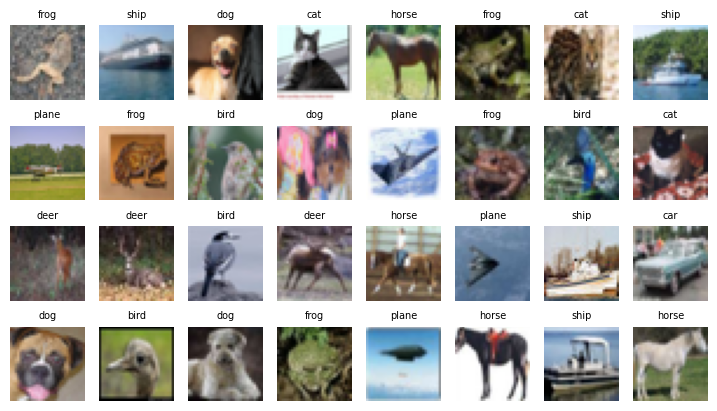

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denormalize(img):
    img=img/2+0.5
    return img

dataiter=iter(trainloader)
images,labels=next(dataiter)

fig,axes=plt.subplots(4,8,figsize=(9,5))

for i in range(batch_size):
    img=denormalize(images[i])
    npimg=img.numpy()
    npimg=np.transpose(npimg,(1,2,0)) # (Channels,Height,Width) → (Height,Width,Channels)

    row = i//8
    col = i%8
    axes[row,col].imshow(npimg)
    axes[row,col].set_title(classes[labels[i]], fontsize=7)
    axes[row,col].axis('off')

plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net = Net()

In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

model = Net()
summary(model,input_size=(3,32,32),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             456
         MaxPool2d-2            [32, 6, 14, 14]               0
            Conv2d-3           [32, 16, 10, 10]           2,416
         MaxPool2d-4             [32, 16, 5, 5]               0
            Linear-5                  [32, 120]          48,120
            Linear-6                   [32, 84]          10,164
            Linear-7                   [32, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.98
Params size (MB): 0.24
Estimated Total Size (MB): 2.59
----------------------------------------------------------------


In [ ]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
from torch.utils.data import random_split,DataLoader
train_size=int(0.8*len(trainset))  #40,000
val_size=len(trainset)-train_size  #10,000
train_dataset,val_dataset=random_split(trainset,[train_size,val_size])

batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
num_epochs=10
train_losses,val_losses=[],[]
train_accuracies,val_accuracies=[],[]

for epoch in range(num_epochs):
    net.train()
    running_loss=0.0
    correct,total=0,0
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    train_loss=running_loss/len(train_loader)
    train_acc=100*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    net.eval()
    val_loss=0.0
    correct,total=0,0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=net(inputs)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            _, predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()

    val_loss/=len(val_loader)
    val_acc=100*correct/total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10 - Train Loss: 1.6480, Train Acc: 39.26% | Val Loss: 1.4007, Val Acc: 49.14%
Epoch 2/10 - Train Loss: 1.3431, Train Acc: 51.20% | Val Loss: 1.2870, Val Acc: 53.33%
Epoch 3/10 - Train Loss: 1.2204, Train Acc: 56.47% | Val Loss: 1.1926, Val Acc: 56.51%
Epoch 4/10 - Train Loss: 1.1354, Train Acc: 59.25% | Val Loss: 1.1663, Val Acc: 58.33%
Epoch 5/10 - Train Loss: 1.0704, Train Acc: 61.90% | Val Loss: 1.1134, Val Acc: 60.65%
Epoch 6/10 - Train Loss: 1.0115, Train Acc: 64.23% | Val Loss: 1.1039, Val Acc: 61.57%
Epoch 7/10 - Train Loss: 0.9629, Train Acc: 65.89% | Val Loss: 1.0783, Val Acc: 62.42%
Epoch 8/10 - Train Loss: 0.9162, Train Acc: 67.33% | Val Loss: 1.0898, Val Acc: 61.24%
Epoch 9/10 - Train Loss: 0.8815, Train Acc: 68.70% | Val Loss: 1.0765, Val Acc: 62.50%
Epoch 10/10 - Train Loss: 0.8485, Train Acc: 69.62% | Val Loss: 1.1247, Val Acc: 62.25%


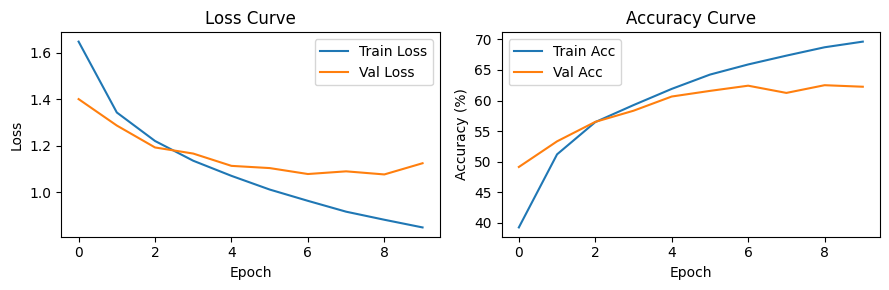

In [ ]:
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies,label='Train Acc')
plt.plot(val_accuracies,label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
correct_pred={classname:0 for classname in classes}
total_pred={classname:0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _, predictions=torch.max(outputs, 1)
        for label,prediction in zip(labels,predictions):
            if label==prediction:
                correct_pred[classes[label]]+=1
            total_pred[classes[label]]+=1

for classname,correct_count in correct_pred.items():
    accuracy=100*float(correct_count)/total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.2 %
Accuracy for class: car   is 73.0 %
Accuracy for class: bird  is 55.9 %
Accuracy for class: cat   is 41.1 %
Accuracy for class: deer  is 46.4 %
Accuracy for class: dog   is 52.2 %
Accuracy for class: frog  is 73.5 %
Accuracy for class: horse is 64.5 %
Accuracy for class: ship  is 79.4 %
Accuracy for class: truck is 79.1 %


In [ ]:
net.eval()
correct=0
total=0

with torch.no_grad():
    for inputs,labels in testloader:
        outputs=net(inputs)
        _, predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

test_accuracy=100*correct/total
print(f'Final Test Accuracy of the model: {test_accuracy:.2f}%')

Final Test Accuracy of the model: 62.73%
